In [1]:
# Need to install gluoncv and mxnet

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
from gluoncv import data, utils
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
coco=COCO('../../dataset/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


In [3]:
# Open the validation dataset
val_dataset = data.COCODetection('../../dataset',splits=['instances_val2017'])
print('Num of validation images:', len(val_dataset))
print(type(val_dataset))

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
Num of validation images: 4952
<class 'gluoncv.data.mscoco.detection.COCODetection'>


In [86]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
accessory appliance outdoor furniture kitchen food electronic animal indoor vehicle sports person


(1, 5)
Image size (height, width, RGB): (640, 480, 3)
Num of objects: 1
Bounding boxes (num_boxes, x_min, y_min, x_max, y_max):
 [[232.6  340.59 380.4  564.96]]
Class IDs (num_boxes, ):
 [[61.]]
(1, 4)
(1, 1)


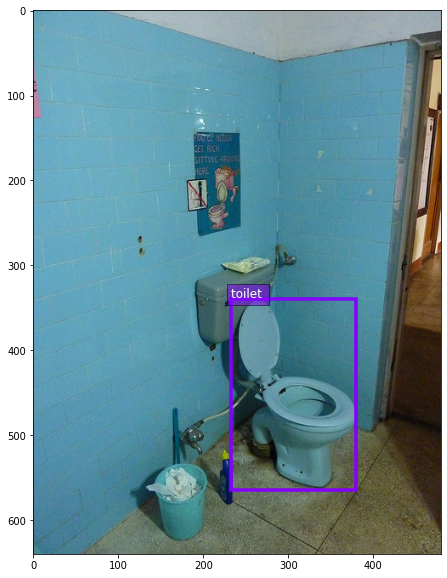

In [4]:
# Sanity check: check to see if bounding box locations load
val_image, val_label = val_dataset[np.random.randint(1, 4000)]  # Display random image
bounding_boxes = val_label[:, :4]
class_ids = val_label[:, 4:5]
print(val_label.shape)
print('Image size (height, width, RGB):', val_image.shape)
print('Num of objects:', bounding_boxes.shape[0])
print('Bounding boxes (num_boxes, x_min, y_min, x_max, y_max):\n',
      bounding_boxes)
print('Class IDs (num_boxes, ):\n', class_ids)
print(bounding_boxes.shape)
print(class_ids.shape)

utils.viz.plot_bbox(val_image.asnumpy(), bounding_boxes, scores=None, labels=class_ids, class_names=val_dataset.classes)
plt.show()


In [36]:
import os
import json

# Load composite bounding box json file
dir = '../../dataset/composite/'
filename = os.path.join(dir, 'test' + '/data.json')
with open(filename) as f:
    data = json.load(f)

dir = '../../dataset/composite/'
classes = json.load(open(os.path.join(dir, 'train/labels.json')))

def bbox_loss(bounding_boxes, bbox):
    """
    @param bounding_boxes - list: contains list as elements, each specifying a bounding box
    @param bbox - dict: contains keys for one bounding box of Quick! Draw sketch (coordinates, id, etc.)

    Here, loss is defined as the Euclidean distance between the boxes.

    Returns
        (1) The "loss" of the best match (the maximum is the best)
        (2) The index of the bounding box that best matches it
    """
    # Init
    best_match_loss = None
    best_match_idx = -1
    overlap = None

    bbox_coords = bbox['bbox']  # Gets bounding box coordinates for the composite image
    for idx in range(len(bounding_boxes)):
        bounding_box = bounding_boxes[idx]
        top_left_dist = np.sqrt(np.square(bbox_coords[0] - bounding_box[0]) + np.square(bbox_coords[1] - bounding_box[1]))
        bottom_right_dist = np.sqrt(np.square(bbox_coords[2] - bounding_box[2]) + np.square(bbox_coords[3] - bounding_box[3]))
        loss = top_left_dist + bottom_right_dist


        if best_match_loss == None or loss < best_match_loss:
            best_match_loss = loss
            best_match_idx = idx

    return best_match_loss, best_match_idx


def loss_one_image(bounding_boxes, class_ids, img, class_weight=0.9, bbox_weight=0.1):
    """
    Returns the loss in comparing composite image to one image in the COCO dataset
    @param bounding_boxes - list: contains lists as elements, each specifiying a bounding box 
    for an image
    @param class_ids - list
    @param img - dict: takes in a dictionary of image data
    @param class_weight - float: how much to weight bounding box discrepancy
    @param bbox_weight - float: how much to weight class discrepancy
    """
    annotations = img['annotations']  # List of bbox annotations
    loss = 0
    for bbox in annotations:
        loss_bbox, best_match_idx = bbox_loss(bounding_boxes, bbox) # For the best bbox, loss and best_match_idx
        class_id_best = class_ids[best_match_idx][0] # Gets label for that box
        class_id_sketch = coco.getCatIds(classes[bbox['category_id']]) # Gets label for the class in COCO
        if len(class_id_sketch) == 0:
            loss_class = 1
        else:
            class_id_sketch = class_id_sketch[0]
            if class_id_best == class_id_sketch:
                loss_class = 0
            else:
                loss_class = 1
        loss += class_weight * loss_class + bbox_weight * loss_bbox

    return loss

def find_nearest_neighbor(dataset, img):
    best_loss = -1
    best_match = None
    for i in range(len(dataset)):
        val_image, val_label = dataset[i]  # Get image
        bounding_boxes = val_label[:, :4]
        class_ids = val_label[:, 4:5]
        loss = loss_one_image(bounding_boxes, class_ids, img)

        if best_loss == -1 or loss < best_loss:
            best_loss = loss
            best_match = val_image

    return best_match

In [39]:
# Test bounding box loss
test_image = {"file_name": "/Users/linden/Desktop/final_project/PicIt/data/../dataset/composite/test/0000004.jpg", "height": 224, "width": 224, "image_id": 4, "annotations": [{"bbox": [123, 87, 156, 120], "bbox_mode": 0, "category_id": 1}, {"bbox": [56, 135, 129, 208], "bbox_mode": 0, "category_id": 1}]}

best_match = find_nearest_neighbor(val_dataset, test_image)

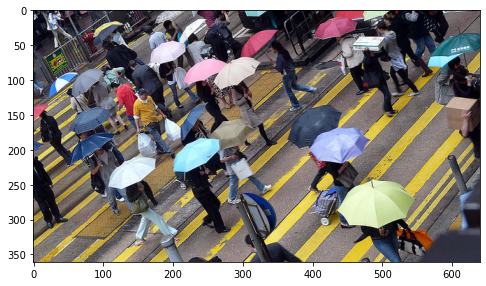

In [40]:
utils.viz.plot_image(best_match.asnumpy())
plt.show()

In [27]:
coco.getCatIds('apple')[0]

53